In [3]:
import os
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import healpy as hp
import lsst.sims.maf.metrics as metrics
import lsst.sims.maf.slicers as slicers
import lsst.sims.maf.metricBundles as metricBundles
import lsst.sims.maf.db as db


In [4]:
# connect to opsim database
opsdb_baseline = db.OpsimDatabase('baseline2018a.db')
# output directory
outDir = 'outdir'
resultsDb = db.ResultsDb(outDir=outDir)

## get dataSlice

In [1]:
from mycode import getDataMetric

In [5]:
transmetric = getDataMetric(colname=['observationStartMJD', 'fieldId','fiveSigmaDepth', 'filter'])

# ra,dec of ipix 
ra = np.array([255.9375])
dec = np.array([0.0])
slicer = slicers.UserPointsSlicer(ra, dec)

sqlconstraint = 'night<730 and proposalId=3'
transmetricSky = metricBundles.MetricBundle(transmetric,slicer,sqlconstraint)

group = metricBundles.MetricBundleGroup({'transmetricSky':transmetricSky}, opsdb_baseline, outDir=outDir, resultsDb=resultsDb)
group.runAll()

Querying database SummaryAllProps with constraint night<730 and proposalId=3 for columns ['fieldDec', 'fiveSigmaDepth', 'filter', 'fieldRA', 'observationStartMJD']
Found 391886 visits
Running:  ['transmetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.


In [21]:
dataSlice = transmetricSky.metricValues.data[0]
dataSlice.shape

(213,)

## test function run()

In [72]:
# plot light curve
def plotlc(dataSlice, time_key='time', mag_key='mag', filter_key='filter', err_key = None,
          peakEpoch=None, nearPeakT=None, postPeakT=None):
    # Input: dataSlice, pandas DataFrame or numpy ndarray
    
    colors = {'u':'k', 'g':'b', 'r':'r', 'i':'m', 'z':'orange', 'y':'c'}
    
    plt.figure(figsize=(10, 6))
    for f in np.unique(dataSlice[filter_key]):
        fmatch = dataSlice[filter_key]==f
        time = dataSlice[time_key][fmatch]
        mag = dataSlice[mag_key][fmatch]
        
        # draw a vertical line to denote pre/near/post peak
        if peakEpoch!=None:
            plt.axvline(x=peakEpoch, linestyle='-', linewidth=1)
            plt.axvline(x=peakEpoch-nearPeakT/2, linestyle='--', linewidth=1)
            plt.axvline(x=peakEpoch+nearPeakT/2, linestyle='--', linewidth=1)
            plt.axvline(x=peakEpoch+nearPeakT/2+postPeakT, linestyle='--', linewidth=1)
        
        if err_key!=None:
            mag_err = dataSlice[err_key][fmatch]
            plt.errorbar(time, mag, yerr=mag_err, color=colors[f], fmt='.', label=f)
        else:
            plt.scatter(time, mag, color=colors[f], marker='*', label=f)

    plt.legend()
    plt.xlabel('days')
    plt.ylabel('mag')
    plt.ylim(plt.ylim()[::-1])


In [25]:
def read_lightCurve(asciifile):
        
    if not os.path.isfile(asciifile):
        raise IOError('Could not find lightcurve ascii file %s' % (asciifile))

    lcv_template = np.genfromtxt(asciifile, dtype=[('ph', 'f8'), ('mag', 'f8'), ('flt', 'S1')])
    return lcv_template

def make_lightCurve(asciifile, time, filters):
                
    lcv_template = read_lightCurve(asciifile)
        
    lcMags = np.zeros(time.size, dtype=float)
        
    for f in set(lcv_template['flt']):
        fMatch_ascii = np.where(np.array(lcv_template['flt']) == f)[0]

        # Interpolate the lightcurve template to the times of the observations, in this filter.
        lc_ascii_filter = np.interp(time, np.array(lcv_template['ph'], float)[fMatch_ascii],
                                            np.array(lcv_template['mag'], float)[fMatch_ascii])
        lcMags[filters == f.decode("utf-8")] = lc_ascii_filter[filters == f.decode("utf-8")]
        
    return lcMags


(30, 20)

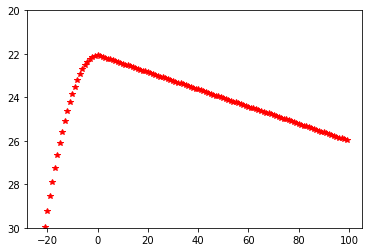

In [29]:
# test read and make light curve
asciifile = 'TDEfaintfast_z0.1.dat'
time = np.arange(-22, 100)
filters = np.repeat('r',len(time))
lcMags = make_lightCurve(asciifile, time, filters)

plt.plot(time, lcMags, 'r*')
plt.ylim([30, 20])

In [57]:
# self.*
asciifile = 'TDEfaintfast_z0.1.dat'
mjdCol = 'observationStartMJD'
m5Col = 'fiveSigmaDepth'
filterCol = 'filter'

epochStart = -22
detectSNR={'u': 5, 'g': 5, 'r': 5, 'i': 5, 'z': 5, 'y': 5}

transDuration = 130

# sort dataSlice in order of time
dataSlice.sort(order=mjdCol)
# average event rate
objRate = 0.02

survey_length = dataSlice[mjdCol].max() - dataSlice[mjdCol].min()

# how many light curve occured
nLc = np.random.poisson(objRate * survey_length)

# random start time

t0 = np.random.randint(0, int(survey_length), nLc) + dataSlice[mjdCol].min()



In [90]:
dataSlice[mjdCol]

array([ 60025.41153935,  60030.40061343,  60031.39601852,  60033.37709491,
        60033.40266204,  60035.37759259,  60036.38319444,  60036.39987269,
        60037.37810185,  60037.39190972,  60047.34407407,  60047.35689815,
        60048.37084491,  60048.39052083,  60051.34148148,  60052.32582176,
        60053.30560185,  60056.32642361,  60061.31353009,  60061.33741898,
        60062.35261574,  60062.37488426,  60063.31336806,  60063.34054398,
        60064.2653125 ,  60065.26326389,  60069.23497685,  60069.2549537 ,
        60073.21974537,  60073.27230324,  60073.28670139,  60074.36127315,
        60076.26104167,  60076.28159722,  60077.30822917,  60077.33052083,
        60095.21458333,  60101.1849537 ,  60103.22459491,  60113.14131944,
        60121.10671296,  60121.15743056,  60121.17712963,  60122.09635417,
        60122.15655093,  60122.17806713,  60123.06481481,  60124.14135417,
        60124.15751157,  60125.21252315,  60128.04188657,  60129.20052083,
        60129.21334491,  

In [89]:
t0

array([ 60120.41153935,  60114.41153935,  60272.41153935,  60483.41153935,
        60456.41153935,  60399.41153935,  60422.41153935,  60065.41153935])

In [102]:
import lsst.sims.maf.utils as utils

In [117]:
lcDictList = []
nDetected = 0
for i, t0_i in enumerate(t0):
    lcIdx = (dataSlice[mjdCol] >= t0_i) & (dataSlice[mjdCol] <= t0_i + transDuration)
    
    lcMjd = dataSlice[mjdCol][lcIdx]
    lcEpoch = lcMjd - t0_i + epochStart
    lcFilters = dataSlice[filterCol][lcIdx]
    
    # make light curve
    lcMags = make_lightCurve(asciifile, lcEpoch, lcFilters)
    m5 = dataSlice[m5Col][lcIdx]
    
    # check SNR for each filter
    lcSNR = utils.m52snr(lcMags, m5)
    
    lcAboveThresh = np.zeros(len(lcSNR), dtype=bool)
    for f in np.unique(lcFilters):
        filtermatch = np.where(lcFilters==f)
        lcAboveThresh[filtermatch] = np.where(lcSNR[filtermatch]>=detectSNR[f], True, False)
    
    # -----------------------------
    # assume detected 
    lcDetect = True
    # check all conditions if fails set lcDetect to False
    
    # check total number of observations for each band
    for f in np.unique(lcFilters):
        filtermatch = np.where(lcFilters==f)

    # check number of observations before peak 
    
    # check number of observations near peak for each band
    
    if lcDetect==True:
        nDetected += 1
    
    lcDict = {'lcN': i, 'lcMjd': lcMjd, 'lcEpoch': lcEpoch, 'lcFilters': lcFilters,
              'lcMags': lcMags, 'm5': m5, 'lcSNR': lcSNR, 'lcAboveThresh':lcAboveThresh,
              'detected': lcDetect}
    
    lcDictList.append(lcDict)


# return 
print(float(nDetected/nLc))

lcOut = pd.DataFrame(lcDictList[5])
lcOut

1.0


,detected,lcAboveThresh,lcEpoch,lcFilters,lcMags,lcMjd,lcN,lcSNR,m5
0,True,False,-19.999016,y,30.116548,60401.412523,5,0.001425,21.253585
1,True,False,-17.077199,i,27.641567,60404.334340,5,0.129025,23.670826
2,True,False,-17.058125,i,27.629949,60404.353414,5,0.130677,23.673018
3,True,True,-8.107824,r,23.242347,60413.303715,5,17.339908,24.592539
4,True,True,-8.089109,r,23.236733,60413.322431,5,17.196607,24.577915
5,True,False,3.983900,z,22.821086,60425.395440,5,2.507941,22.071955
6,True,False,4.009178,z,22.822235,60425.420718,5,2.821655,22.201070
7,True,False,6.853912,y,23.209233,60428.265451,5,1.381925,21.813019
8,True,False,6.963762,z,22.943228,60428.375301,5,3.761878,22.634314
9,True,False,6.980012,z,22.943819,60428.391551,5,3.648060,22.601548


In [114]:
lcOut += pd.DataFrame(lcDictList[1])


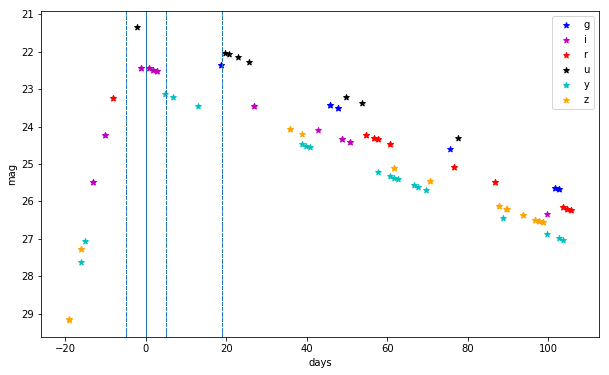

In [125]:
lcOut = pd.DataFrame(lcDictList[6])

plotlc(lcOut, time_key='lcEpoch', mag_key='lcMags', filter_key='lcFilters', err_key = None,
          peakEpoch=0, nearPeakT=10, postPeakT=14)
    
    

In [59]:
t0

array([ 60120.41153935,  60114.41153935,  60272.41153935,  60483.41153935,
        60456.41153935,  60399.41153935,  60422.41153935,  60065.41153935])

In [35]:
mjdCol = 'observationStartMJD'

dataSlice.sort(order=mjdCol)
lcIdx = (dataSlice[mjdCol]>60129) & (dataSlice[mjdCol]<60500)
dataSlice[mjdCol][lcIdx]

array([ 60129.20052083,  60129.21334491,  60130.14793981,  60130.16766204,
        60131.18984954,  60131.21015046,  60137.09731481,  60137.1165625 ,
        60139.07251157,  60140.10989583,  60140.12451389,  60142.11428241,
        60142.13998843,  60143.1122338 ,  60143.13167824,  60144.1078588 ,
        60144.12885417,  60148.04215278,  60149.04445602,  60150.1040162 ,
        60150.11972222,  60151.1046412 ,  60151.11740741,  60152.07100694,
        60158.10980324,  60158.12302083,  60166.031875  ,  60166.04354167,
        60167.02260417,  60168.00083333,  60169.00736111,  60175.98885417,
        60177.00884259,  60178.97136574,  60179.97140046,  60179.98524306,
        60182.97559028,  60182.99001157,  60184.01311343,  60184.03454861,
        60184.98797454,  60192.97759259,  60367.40081019,  60368.37559028,
        60394.29694444,  60395.28930556,  60396.33347222,  60397.32372685,
        60397.33729167,  60401.41252315,  60404.33434028,  60404.35341435,
        60413.30371528,  